<a href="https://colab.research.google.com/github/workVipulPareek/Hate_Speech_Classifier/blob/main/endSemLabProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Menu:
1. Train and save the model
2. Load and use the saved model on the test set
3. Exit
Enter your choice: 1
Models and vectorizer saved successfully.
Logistic Regression - Validation accuracy: 95.62%
Logistic Regression - Test accuracy: 95.41%

Logistic Regression - Validation Set Metrics:


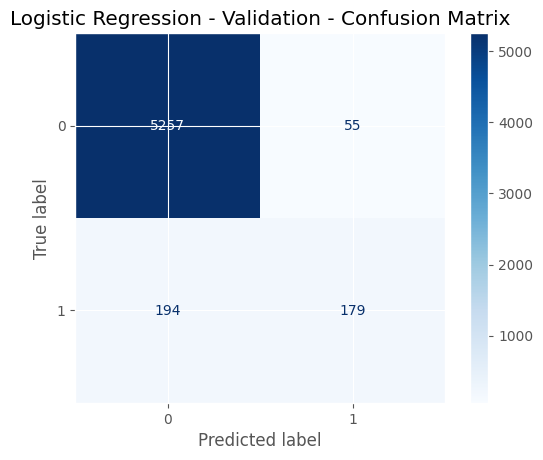

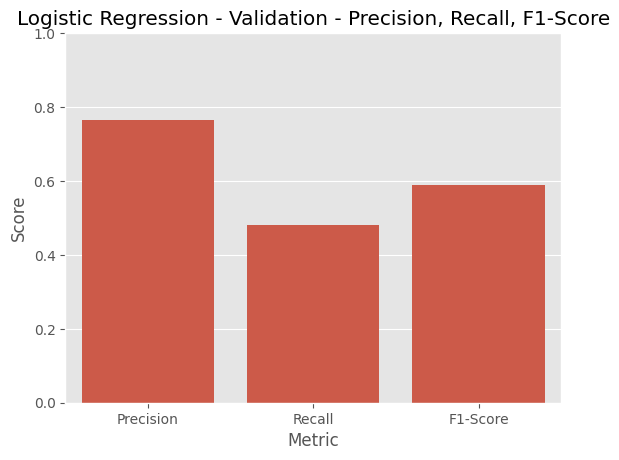


Logistic Regression - Test Set Metrics:


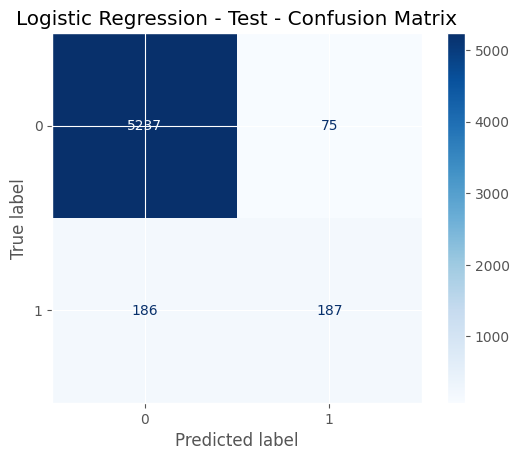

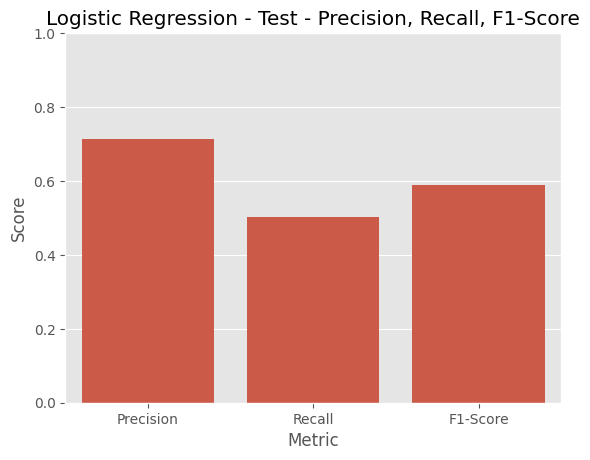

Random Forest - Validation accuracy: 95.09%
Random Forest - Test accuracy: 94.72%

Random Forest - Validation Set Metrics:


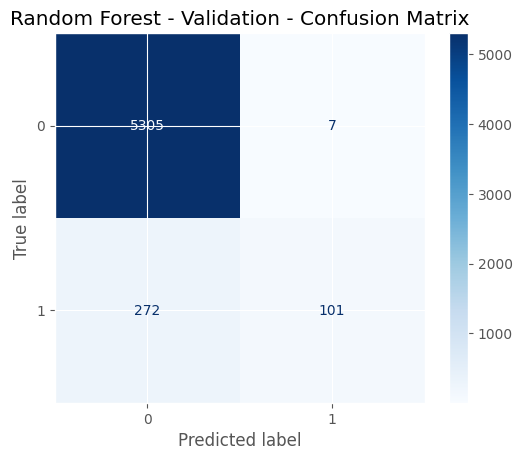

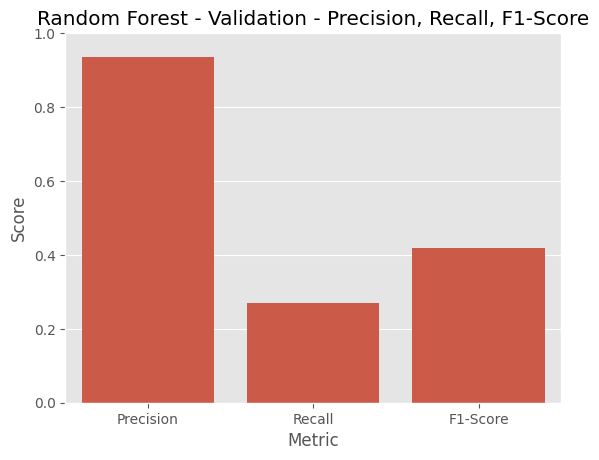


Random Forest - Test Set Metrics:


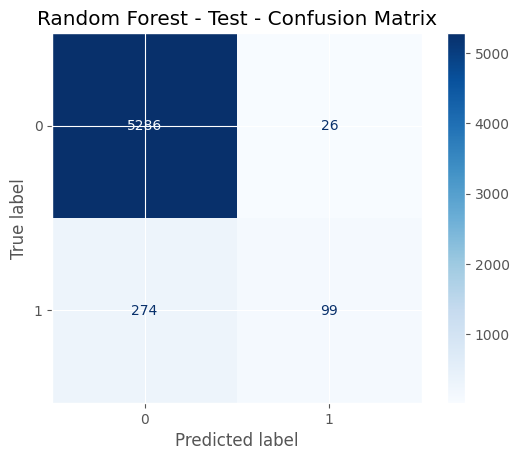

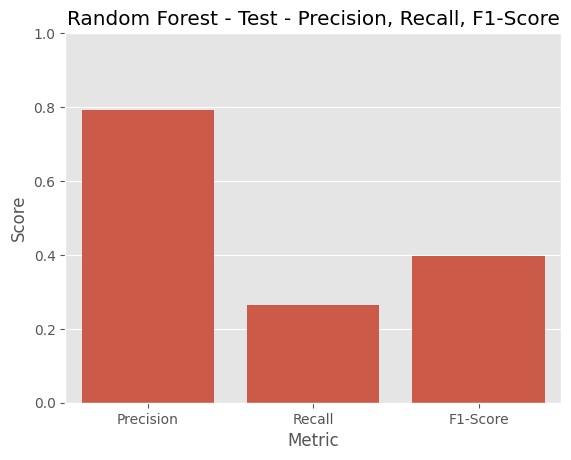


Menu:
1. Train and save the model
2. Load and use the saved model on the test set
3. Exit
Enter your choice: 2
Logistic Regression - Test accuracy: 95.41%


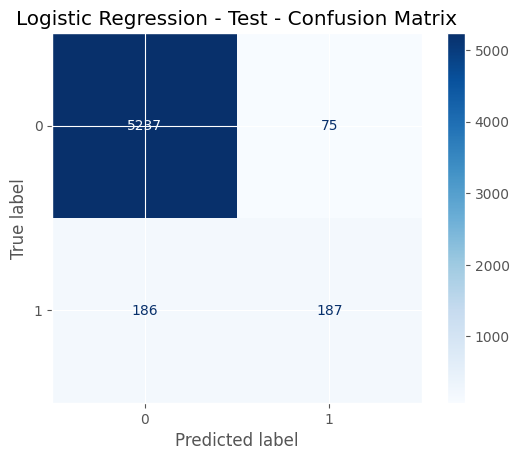

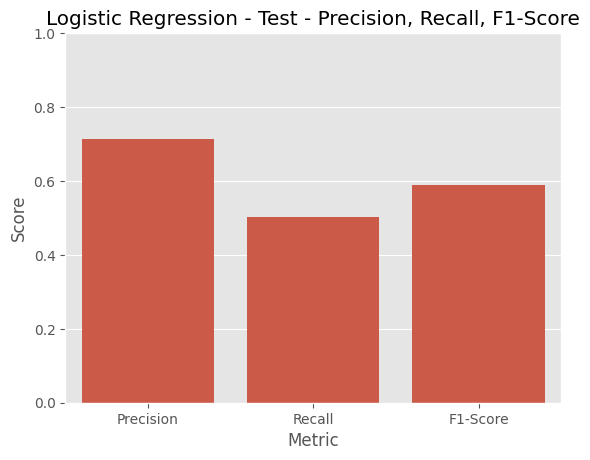

Random Forest - Test accuracy: 94.72%


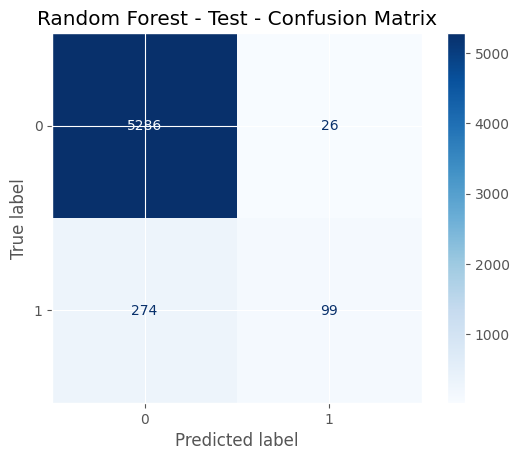

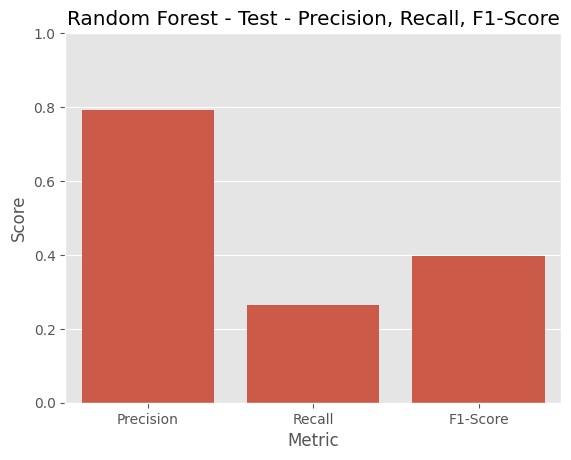


Menu:
1. Train and save the model
2. Load and use the saved model on the test set
3. Exit


KeyboardInterrupt: Interrupted by user

In [5]:
# coding: utf-8

# Import required libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import pickle
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from sklearn.utils import shuffle

# Set up plotting style
style.use('ggplot')

# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Data processing functions
def data_processing(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r"https\S+|www\S+http\S+", '', tweet, flags=re.MULTILINE)
    tweet = re.sub(r'\@\w+|\#', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = re.sub(r'ð', '', tweet)
    tweet_tokens = word_tokenize(tweet)
    filtered_tweets = [w for w in tweet_tokens if not w in stop_words]
    return " ".join(filtered_tweets)

lemmatizer = WordNetLemmatizer()
def lemmatizing(data):
    return " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(data)])

# Function to display model evaluation metrics
def plot_metrics(y_true, y_pred, model_name):
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # Precision, Recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F1-Score'],
        'Score': [precision, recall, f1]
    })

    sns.barplot(x='Metric', y='Score', data=metrics_df)
    plt.ylim(0, 1)
    plt.title(f"{model_name} - Precision, Recall, F1-Score")
    plt.show()

# Function to train and save models
def train_and_save_model():
    # Load the dataset
    tweet_df = pd.read_csv(r'/content/train.csv')

    # Preprocess the data
    tweet_df['tweet'] = tweet_df['tweet'].apply(data_processing)
    tweet_df = tweet_df.drop_duplicates('tweet')
    tweet_df['tweet'] = tweet_df['tweet'].apply(lemmatizing)

    # Split data into train, validation, and test sets (60%, 20%, 20%)
    X = tweet_df['tweet']
    Y = tweet_df['label']
    x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
    x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Vectorize the data
    vect = TfidfVectorizer(ngram_range=(1,3)).fit(x_train)
    x_train = vect.transform(x_train)
    x_val = vect.transform(x_val)
    x_test = vect.transform(x_test)

    # Logistic Regression with Hyperparameter Tuning
    logreg = LogisticRegression()
    param_grid_logreg = {'C': [100, 10, 1.0, 0.1, 0.01], 'solver': ['newton-cg', 'lbfgs', 'liblinear']}
    grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, n_jobs=-1)
    grid_logreg.fit(x_train, y_train)
    logreg_best = grid_logreg.best_estimator_

    # Random Forest with Hyperparameter Tuning
    rf = RandomForestClassifier(n_jobs=-1)
    param_grid_rf = {'n_estimators': [10, 50, 100], 'max_depth': [None, 5, 10]}
    grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
    grid_rf.fit(x_train, y_train)
    rf_best = grid_rf.best_estimator_

    # Save the models and vectorizer
    with open('logreg_best_model.pkl', 'wb') as file:
        pickle.dump(logreg_best, file)
    with open('rf_best_model.pkl', 'wb') as file:
        pickle.dump(rf_best, file)
    with open('tfidf_vectorizer.pkl', 'wb') as file:
        pickle.dump(vect, file)

    print("Models and vectorizer saved successfully.")

    # Display and plot validation and test accuracy and metrics
    for model, name in [(logreg_best, "Logistic Regression"), (rf_best, "Random Forest")]:
        val_pred = model.predict(x_val)
        test_pred = model.predict(x_test)
        print(f"{name} - Validation accuracy: {accuracy_score(y_val, val_pred) * 100:.2f}%")
        print(f"{name} - Test accuracy: {accuracy_score(y_test, test_pred) * 100:.2f}%")

        # Plot metrics for validation and test sets
        print(f"\n{name} - Validation Set Metrics:")
        plot_metrics(y_val, val_pred, f"{name} - Validation")

        print(f"\n{name} - Test Set Metrics:")
        plot_metrics(y_test, test_pred, f"{name} - Test")

# Function to load and use saved models on the test set
def load_and_evaluate_model():
    # Load the models and vectorizer
    with open('logreg_best_model.pkl', 'rb') as file:
        loaded_logreg = pickle.load(file)
    with open('rf_best_model.pkl', 'rb') as file:
        loaded_rf = pickle.load(file)
    with open('tfidf_vectorizer.pkl', 'rb') as file:
        loaded_vect = pickle.load(file)

    # Load the dataset for test data only
    tweet_df = pd.read_csv(r'/content/train.csv')
    tweet_df['tweet'] = tweet_df['tweet'].apply(data_processing)
    tweet_df = tweet_df.drop_duplicates('tweet')
    tweet_df['tweet'] = tweet_df['tweet'].apply(lemmatizing)

    # Split data into test set
    X = tweet_df['tweet']
    Y = tweet_df['label']
    _, x_temp, _, y_temp = train_test_split(X, Y, test_size=0.4, random_state=42, stratify=Y)
    _, x_test, _, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

    # Shuffle the test set
    x_test, y_test = shuffle(x_test, y_test, random_state=42)

    # Transform the test data
    x_test_transformed = loaded_vect.transform(x_test)

    # Evaluate and plot results for both models on the test data
    for model, name in [(loaded_logreg, "Logistic Regression"), (loaded_rf, "Random Forest")]:
        test_pred = model.predict(x_test_transformed)
        test_acc = accuracy_score(y_test, test_pred)
        print(f"{name} - Test accuracy: {test_acc * 100:.2f}%")

        # Plot metrics for test set
        plot_metrics(y_test, test_pred, f"{name} - Test")

# Main menu
def main():
    while True:
        print("\nMenu:")
        print("1. Train and save the model")
        print("2. Load and use the saved model on the test set")
        print("3. Exit")
        choice = input("Enter your choice: ")

        if choice == '1':
            train_and_save_model()
        elif choice == '2':
            load_and_evaluate_model()
        elif choice == '3':
            print("Exiting the program.")
            break
        else:
            print("Invalid choice. Please try again.")

if __name__ == "__main__":
    main()
